***Changelog*** Created 5/29/21

---
*   **[1.0.0 Alpha]** plan to implement various costs + activation classes, but gradient descent optimizer only.

*   **[1.0.1 Alpha]** use of parent classes for activations & losses to inherit from

*   **[1.0.2 Alpha]** feedforward and backpropagation are now two separate functions for better readability.

*   **[1.0.3 Alpha]** activation & loss are currently passed as class instances to Network, but plan to revert back to the old dictionary method /w string keys.

*   **[1.0.0]** Currently functional after correcting incorrect loss derivative function.

*   **[1.1.0]** Recombined batch_ff and backprop functions to remove the need for global variables to store zs and activations

*   **[1.2.0]** Replaced backprop matrix ops with einsum equivalents. This also removes the need to sum over the batch axes, as einsum does it for me :))))) THIS SPEEDS UP TRAINING TIME SIGNIFICANTLY WOOOHOOOOO

*   **[1.2.0]** Added 'history' dictionary to store various logistics over course of training for diagnostic purposes.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
class DefaultLoss():
  def f(self, x, y):
    return 0.5*(x-y)**2
  
  def prime(self, x, y):
    return x-y

class MSE(DefaultLoss):
  pass

class CrossEntropy(DefaultLoss):
  pass


In [ ]:
class DefaultActivation(): # Base class for activations implements sigmoid activation.
  def f(self, z):
    return 1.0/(1.0+np.exp(-z))
  
  def prime(self, z):
    return self.f(z) * (1.0-self.f(z))

  def delta(self, z, a, y, Loss):
    return Loss.prime(a, y) * self.prime(z)**(type(Loss)!=CrossEntropy) # shorthand to exclude sigmoid_prime(z) when using Cross Entropy loss

class Sigmoid(DefaultActivation):
  pass

In [ ]:
def to_one_hot(data, max):
  output = []
  for index in data:
    one_hot = np.zeros((max, 1))
    one_hot[index][0] = 1
    output.append(one_hot)
  return np.array(output)

In [ ]:
class Network():
  def __init__(self, sizes, Activation, Loss):
    self.sizes = sizes # array of dimensions for each layer in model
    self.num_layers = len(sizes)
    self.b = [np.random.standard_normal([i,1]) for i in sizes[1:]] # array of biases for each layer in model
    self.w = [np.random.standard_normal([o, i])/np.sqrt(i) for i, o in zip(sizes[:-1], sizes[1:])] # array of weights for each layer in model
    self.R = Activation
    self.L = Loss
    self.history = {"epochs":[], "accuracy":[], "val_accuracy":[]}

  def summary(self):
    print("SUMMARY\n----------------------------")
    print(f"Number of Layers = {self.num_layers}")
    print(f"Bias Shapes = {[x.shape for x in self.b]}")
    print(f"Weight Shapes = {[x.shape for x in self.w]}")
    print("----------------------------")

  def feedforward(self, a): # feedforward function for evaluation purposes
    for w, b in zip(self.w, self.b):
      a = self.R.f(np.matmul(w, a) + b)
    return a

  def backprop(self, a, y): # calculates gradients of trainable params to be used for gradient descent.
    zs, activations = [], [a] # to store z & a values for backprop
    for w, b in zip(self.w, self.b):
      z = np.matmul(w, a) + b; a = self.R.f(z)
      zs.append(z); activations.append(a)
    grad_w, grad_b = [None]*len(self.w), [None]*len(self.b)
    delta = self.R.delta(zs[-1], activations[-1], y, self.L) # calculate delta-L (partial derivative of z-L with respect to loss)
    grad_w[-1] = np.einsum("...ijk,...ilk->jl", delta, activations[-2])
    grad_b[-1] = np.einsum("ijk->jk", delta)
    for l in range(2, self.num_layers): # -l represents current layer in backprop
      delta = np.einsum("jk,...ijl,...ikl->ikl", self.w[-l+1], delta, self.R.prime(zs[-l]))
      grad_w[-l] = np.einsum("...ijk,...ilk->jl", delta, activations[-l-1])
      grad_b[-l] = np.einsum("ijk->jk", delta)
    return grad_w, grad_b
  
  def mini_batch_step(self, mini_batch, lr): # mini_batch data in format (train_features, train_labels)
    features, labels = mini_batch
    grad_w, grad_b = self.backprop(np.array(features), np.array(labels))
    self.w = [w-(lr/len(features))*nw for w, nw in zip(self.w, grad_w)]
    self.b = [b-(lr/len(features))*nb for b, nb in zip(self.b, grad_b)]

  def SGD(self, dataset, epochs, mini_batch_size, lr, validation_data=None, **kwargs): # dataset data as an iterable of individual (feature, label) pairs
    for i in range(epochs):
      random.shuffle(dataset)
      train_evaluate = dataset[0:len(dataset)//5]
      mini_batches = [zip(*dataset[j:j+mini_batch_size]) for j in range(0, len(dataset), mini_batch_size)]
      for mini_batch in mini_batches:
        self.mini_batch_step(mini_batch, lr)
      print(f"Epoch {i+1} Complete")
      if metrics:
        self.history["accuracy"].append(self.train_evaluate(train_evaluate))
        self.history["epochs"].append(i)
      if validation_data != None:
        val_accuracy = self.evaluate(validation_data)
        print(f"Validation Accuracy: {val_accuracy} (%)")
        self.history["val_accuracy"].append(val_accuracy)

  def train_evaluate(self, train_data): # train_data as an iterable of individual (feature, one hot) pairs
    return round(sum([np.argmax(self.feedforward(feature))==np.argmax(label) for feature, label in train_data])/len(train_data)*100, 2)

  def evaluate(self, test_data): # test_data as an iterable of individual (feature, label) pairs
    return round(sum([np.argmax(self.feedforward(feature))==label for feature, label in test_data])/len(test_data)*100, 2)

  def demo(self, dim, test_dataset):
    plt.figure(figsize=(3*dim,3*dim))
    for i in range(dim**2):
      rand = random.randint(0, len(test_dataset)-1)
      plt.subplot(dim, dim, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(test_batch[rand][0].reshape(28,28))
      plt.xlabel(f"Model Prediction: {np.argmax(self.feedforward(test_batch[rand][0]))}")

In [ ]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.array([x.reshape(-1, 1)/255 for x in x_train])
x_test = np.array([x.reshape(-1, 1)/255 for x in x_test])

x_train, x_validate = (x_train[0:50000], x_train[50000:60000])
y_train, y_validate = (y_train[0:50000], y_train[50000:60000])

y_train = to_one_hot(y_train, 10)

train_batch = [(x, y) for x, y in zip(x_train, y_train)]
test_batch = [(x, y) for x, y in zip(x_test, y_test)]
validate_batch = [(x, y) for x, y in zip(x_validate, y_validate)]

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
x = Network([784, 128, 10], Sigmoid(), CrossEntropy())
x.summary()
x.SGD(train_batch, 10, 64, 0.64, validate_batch)

SUMMARY
----------------------------
Number of Layers = 3
Bias Shapes = [(128, 1), (10, 1)]
Weight Shapes = [(128, 784), (10, 128)]
----------------------------
Epoch 1 Complete
Validation Accuracy: 91.72 (%)
Epoch 2 Complete
Validation Accuracy: 95.03 (%)
Epoch 3 Complete
Validation Accuracy: 95.76 (%)
Epoch 4 Complete
Validation Accuracy: 96.16 (%)
Epoch 5 Complete
Validation Accuracy: 96.72 (%)
Epoch 6 Complete
Validation Accuracy: 97.01 (%)
Epoch 7 Complete
Validation Accuracy: 96.95 (%)
Epoch 8 Complete
Validation Accuracy: 97.13 (%)
Epoch 9 Complete
Validation Accuracy: 97.44 (%)
Epoch 10 Complete
Validation Accuracy: 97.45 (%)


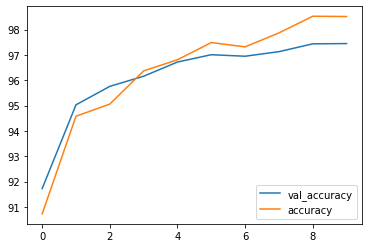

In [ ]:
plt.plot(x.history['val_accuracy'], label = 'val_accuracy')
plt.plot(x.history['accuracy'], label = 'accuracy')
plt.legend(loc='lower right')
pass

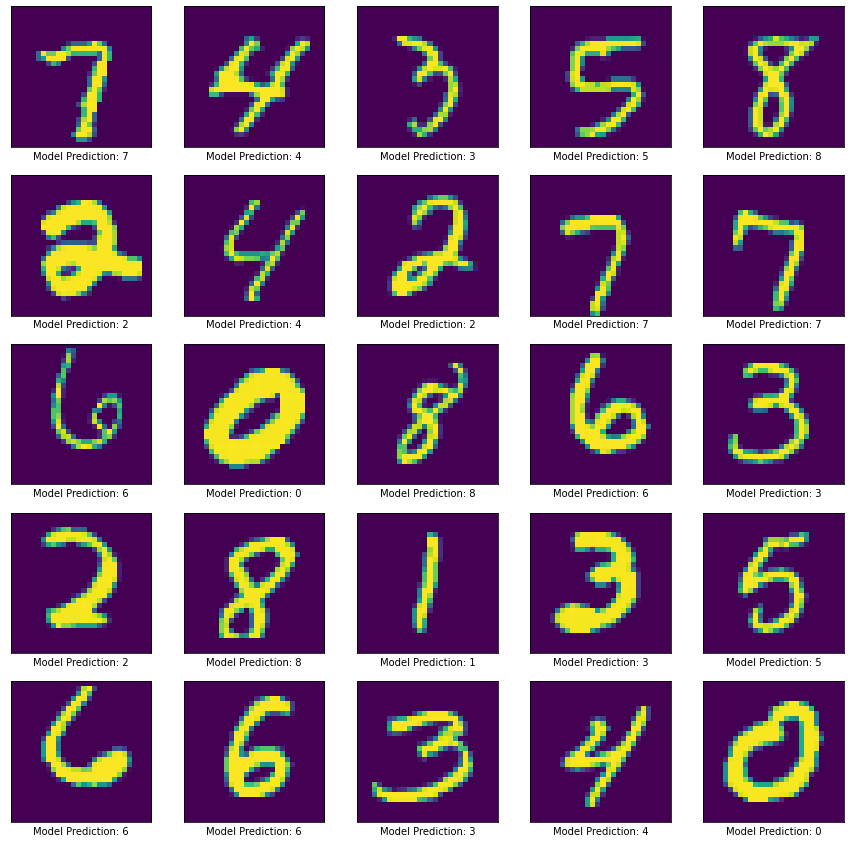

In [ ]:
x.demo(5, test_batch)